In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [32]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')


In [33]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [34]:
train_df.shape

(7613, 5)

In [35]:
train_df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [36]:
drop_columns = ['keyword', 'location']
train_df.drop(columns=drop_columns, inplace=True)
train_df.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [37]:
train_df['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

<Axes: xlabel='target', ylabel='count'>

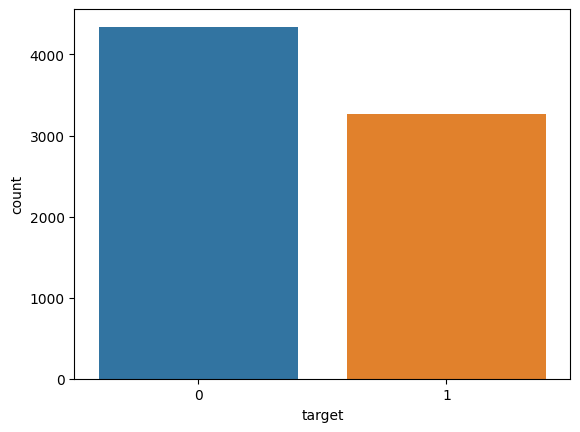

In [38]:
import seaborn as sns

sns.countplot(x=train_df['target'])

In [39]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [40]:
test_df.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [9]:
test_df.shape

(3263, 4)

In [41]:
def preprocess_text(paragraph):
    # Remove references like [1], [2], etc.
    text = re.sub(r'\[[0-9]*\]', ' ', paragraph)
    # Remove URLs starting with http or https
    text = re.sub(r'http\S+|https\S+', '', text)
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hash symbols
    text = re.sub(r'#', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove leading and trailing spaces
    return text.strip()

# Apply the function to all rows in the 'text' column
train_df['text'] = train_df['text'].apply(preprocess_text)
test_df['text']=test_df['text'].apply(preprocess_text)


In [42]:
train_df.head()

,id,text,target
0,1,our deeds are the reason of this earthquake ma...,1
1,4,forest fire near la ronge sask. canada,1
2,5,all residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive wildfires evacuation ord...",1
4,7,just got sent this photo from ruby alaska as s...,1


In [43]:
import spacy
nlp = spacy.load('en_core_web_sm')

def preprocess_texts(text):
    doc = nlp(text)
    filtered_tokens = []
    
    for token in doc:
        if not token.is_stop and not token.is_punct:
            filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens)


In [44]:
train_df['preprocess_text']=train_df.text.apply(preprocess_texts)

In [45]:
test_df['preprocess_text']=test_df.text.apply(preprocess_texts)

In [46]:
X=train_df['preprocess_text']
y=train_df['target']
X_val=test_df['preprocess_text']

In [47]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,
                                            y,
                                            test_size=0.2,
                                            random_state=2024,
                                            stratify=y)

In [48]:
X_train.head()

7187         upload video asap guy new weapon type action
1278                                     burn twice flame
3302    efak design building occupant evacuate report ...
1872                   crush girl high school realize lol
6849    game hope agdq trauma center second opinion ko...
Name: preprocess_text, dtype: object

In [49]:
X_train[7187]

'upload video asap guy new weapon type action'

In [50]:
X_test

2376    24 kill simultaneous rail crash acute flood de...
2607    black eye 9 space battle occur star o784 invol...
5685      like video romanatwoodvlog | rescue sick kitten
3136    survival kit whistle fire starter wire see cre...
6432    lt 25 dead kuwait mosque suicide bombing claim...
                              ...                        
120     wisdomwe bonus 5 minute daily habit improve li...
5090    obama sign deal far make world safe place iran...
3939    flood advisory issue august 05 4:28pm edt nws ...
255                        soul punish withåêannihilation
1004      wwe 2k15 mycareer ep18 tyrone body bagging dude
Name: preprocess_text, Length: 1523, dtype: object

KNN with n_neighbors=10, metric=euclidean

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report


pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 3))),  
    ('clf', KNeighborsClassifier(n_neighbors=10, metric='euclidean'))
])


# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

y_pred=pipeline.predict(X_test)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.61      0.99      0.76       869
           1       0.95      0.17      0.29       654

    accuracy                           0.64      1523
   macro avg       0.78      0.58      0.52      1523
weighted avg       0.76      0.64      0.56      1523



KNN with n_neighbor=10, metric=cosine

In [52]:
# Define the pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 3))),  # Unigrams, bigrams, and trigrams
    ('clf', KNeighborsClassifier(n_neighbors=10, metric='cosine'))
])


# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

y_pred=pipeline.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.73      0.91      0.81       869
           1       0.82      0.56      0.67       654

    accuracy                           0.76      1523
   macro avg       0.78      0.74      0.74      1523
weighted avg       0.77      0.76      0.75      1523



RANDOM FOREST

In [63]:

from sklearn.ensemble import RandomForestClassifier

# Define the pipeline
RF = Pipeline([
    ('vect', CountVectorizer(ngram_range=(3, 3))),  
    ('clf', RandomForestClassifier())  
])



# Fit the pipeline on the training data
RF.fit(X_train, y_train)

y_pred=RF.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.97      0.78       869
           1       0.90      0.30      0.45       654

    accuracy                           0.68      1523
   macro avg       0.77      0.64      0.61      1523
weighted avg       0.76      0.68      0.64      1523



MULTINOMIAL NB with alpha=0.75

In [54]:

from sklearn.naive_bayes import MultinomialNB

# Define the pipeline
NB = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),  # Unigrams and bigrams
    ('clf', MultinomialNB(alpha=0.75))  # Multinomial Naive Bayes classifier with alpha=0.75
])


# Fit the pipeline on the training data
NB.fit(X_train, y_train)

y_pred=NB.predict(X_test)

print(classification_report(y_test,y_pred))



              precision    recall  f1-score   support

           0       0.79      0.84      0.82       869
           1       0.77      0.71      0.74       654

    accuracy                           0.79      1523
   macro avg       0.78      0.78      0.78      1523
weighted avg       0.78      0.79      0.78      1523



Apply preprocess text by removing stop words and apply bag of words

Random Forest with preprocessed text

In [64]:

from sklearn.ensemble import RandomForestClassifier

# Define the pipeline
RF = Pipeline([
    ('vect', CountVectorizer(ngram_range=(3, 3))),  
    ('clf', RandomForestClassifier())  
])



# Fit the pipeline on the training data
RF.fit(X_train, y_train)

y_pred=RF.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.65      0.97      0.78       869
           1       0.90      0.30      0.45       654

    accuracy                           0.68      1523
   macro avg       0.77      0.64      0.61      1523
weighted avg       0.76      0.68      0.64      1523



In [65]:

from sklearn.ensemble import RandomForestClassifier

# Define the pipeline
RF = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),  
    ('clf', RandomForestClassifier())  
])



# Fit the pipeline on the training data
RF.fit(X_train, y_train)

y_pred=RF.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.76      0.91      0.82       869
           1       0.83      0.61      0.70       654

    accuracy                           0.78      1523
   macro avg       0.79      0.76      0.76      1523
weighted avg       0.79      0.78      0.77      1523



In [66]:

from sklearn.ensemble import RandomForestClassifier

# Define the pipeline
RF = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', RandomForestClassifier())  
])



# Fit the pipeline on the training data
RF.fit(X_train, y_train)

y_pred=RF.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81       869
           1       0.78      0.65      0.71       654

    accuracy                           0.77      1523
   macro avg       0.77      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



In [67]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Define the pipeline
NB = Pipeline([
    ('vect', TfidfVectorizer()),  
    ('clf', MultinomialNB(alpha=0.75))  
])


# Fit the pipeline on the training data
NB.fit(X_train, y_train)

y_pred=NB.predict(X_test)

print(classification_report(y_test,y_pred))



              precision    recall  f1-score   support

           0       0.79      0.88      0.83       869
           1       0.81      0.69      0.74       654

    accuracy                           0.80      1523
   macro avg       0.80      0.78      0.79      1523
weighted avg       0.80      0.80      0.79      1523



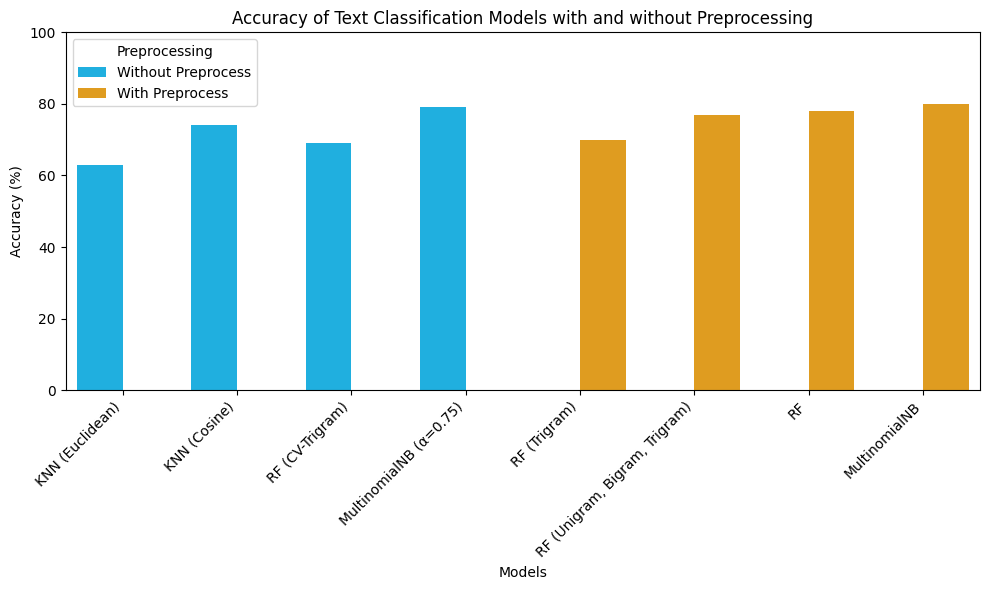

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    'Model': ['KNN (Euclidean)', 'KNN (Cosine)', 'RF (CV-Trigram)', 'MultinomialNB (α=0.75)',
              'RF (Trigram)', 'RF (Unigram, Bigram, Trigram)', 'RF', 'MultinomialNB'],
    'Accuracy (%)': [63, 74, 69, 79, 70, 77, 78, 80],
    'Preprocessing': ['Without Preprocess'] * 4 + ['With Preprocess'] * 4
}

df = pd.DataFrame(data)

# Plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Accuracy (%)', hue='Preprocessing', data=df,
            palette={'Without Preprocess': 'deepskyblue', 'With Preprocess': 'orange'})
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy of Text Classification Models with and without Preprocessing')
plt.ylim(0, 100)  # Set y-axis limit from 0 to 100 for better visualization
plt.legend(title='Preprocessing')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show plot
plt.show()


In [69]:
from sklearn.feature_extraction.text import CountVectorizer

v=CountVectorizer()

X_train_cv=v.fit_transform(X_train.values)
X_train_cv

<6090x11025 sparse matrix of type '<class 'numpy.int64'>'
	with 49327 stored elements in Compressed Sparse Row format>

In [73]:
from sklearn.naive_bayes import MultinomialNB

model=MultinomialNB()
model.fit(X_train_cv,y_train)


MultinomialNB()

In [74]:
X_test_cv=v.transform(X_test)

In [75]:
from sklearn.metrics import classification_report

y_pred=model.predict(X_test_cv)

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.80      0.85      0.82       869
           1       0.78      0.71      0.75       654

    accuracy                           0.79      1523
   macro avg       0.79      0.78      0.79      1523
weighted avg       0.79      0.79      0.79      1523



In [76]:
msg=[
    'Typhoon Soudelor kills 28 in China and Taiwan',
    "They'd probably still show more life than Arsenal did yesterday, eh? EH?"]
msg_count=v.transform(msg)
model.predict(msg_count)

array([1, 0])

In [77]:
# Step 7: Extract the text from the test dataset
X_test = test_df['preprocess_text']

# Step 8: Transform test data using the same CountVectorizer instance
X_test_cv = v.transform(X_test)

# Step 9: Make predictions on test data
test_predictions = model.predict(X_test_cv)

# Step 10: Add predictions to the test dataset
test_df['target'] = test_predictions

# Step 11: Save the id, text, and predictions to a new file
test_df[['id',  'target']].to_csv('test_predictions.csv', index=False)

print("Predictions saved to 'test_predictions.csv'.")


Predictions saved to 'test_predictions.csv'.
